In [1]:
import qcodes as qc
import numpy as np
import matplotlib.pyplot as plt
from qcodes.data.data_set import load_data
import scipy.signal as signal
import scipy
#from qcodes.plots.qcmatplotlib import MatPlot
from qcodes.plots.pyqtgraph import QtPlot

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy import integrate 

import math
from lmfit import Model
import qcodes.dataset.experiment_container as exc
#from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_run_spec, load_by_id

# Functions

In [2]:
def charge_data(id_1): # opens the data 
	'''
    Opens database experiment
    Parameters
    ----------
    id_1: int.
        database id.
    Returns
    -------
    integer: 1d array.
        number of trace
    X: 2d array.
         reflectometry traces in I.
    Y: 2d array.
         reflectometry traces in Q.
    sweep: 1d array.
        Trace time in us.
    '''

	dataset=load_by_id(id_1)

	integer=np.unique(dataset.get_parameter_data()["Distance"]["integer"])
	X=(dataset.get_parameter_data()["I"]["I"])
	Y=(dataset.get_parameter_data()["Q"]["Q"])
	sweep=(dataset.get_parameter_data()["RF_sweep"]["RF_sweep"] )[0]	 

	return integer,X, Y, sweep
def moving_average(a, n=20) :
	'''
    Moving average on array a
    Parameters
    ----------
    a: 1d array.
        array with data.
    n: int.
        length of the moving average. When n=20 a moving average is perform on array a every 20 points
    Returns
    -------
    1d array.
        moving average of array a
    '''
	ret = np.cumsum(a, dtype=float)
	ret[n:] = ret[n:] - ret[:-n]
	return ret[n - 1:] / n 
def IQ_plot(id_1,jupyter_name,sweep, X,Y,signal_start,signal_end, bg_start,bg_end):
	'''
    Plots maximums over two different time intervals in the IQ plane from the traces taken.
    Calculate the center of the signal and std for the maximums over both time intervals.
    The first interval si a mixture between signal and background.
    The second interval corresponds to only background since the bleep (spin up) has already happened.
    Parameters
    ----------
    id_1: int.
        database id.
    integer: 1d array.
        number of trace
    jupyter_name: string.
         title of the plot.
    X: 2d array.
         reflectometry traces in I.
    Y: 2d array.
         reflectometry traces in Q.
    sweep: 1d array.
        Trace time in us.
    signal_start: float.
        start of the first interval in us.
    signal_end: float.
        end of the first interval in us.
    bg_start: float.
        start of the second interval in us.
    bg_end: float.
        end of the second interval in us.
    Returns
    -------
    maximum_X: float.
        mean in I of the maximums during first interval.
    maximum_Y: float.
        mean in Q of the maximums during first interval.
    background_X: float.
        mean in I of the maximums during second interval.
    background_Y: float.
        mean in I of the maximums during second interval.
    '''
	maximum_X=np.zeros(len(X))
	maximum_Y=np.zeros(len(X))

	background_X=np.zeros(len(X))
	background_Y=np.zeros(len(X))

	for a in range(len(X)):
		minim= np.where(sweep>= signal_start)[0][0]
		maxim= np.where(sweep>= signal_end)[0][0]
		maximum_X[a]=X[a][minim:maxim].min()
		maximum_Y[a]=Y[a][minim:maxim].max()

		minim= np.where(sweep>= bg_start)[0][0]
		maxim= np.where(sweep>= bg_end)[0][0]
		background_X[a]=X[a][minim:maxim].min()
		background_Y[a]=Y[a][minim:maxim].max()
		
	fig_width_pt = 320.0  # Get this from LaTeX using \showthe\columnwidth
	inches_per_pt = 1.0/72.27				# Convert pt to inch
	golden_mean = (math.sqrt(5)-1.0)/2.0		 # Aesthetic ratio
	fig_width = fig_width_pt*inches_per_pt	# width in inches
	fig_height = fig_width		# height in inches
	fig_size =	[fig_width,fig_height]
	plt.rcParams['legend.fontsize'] = 8
	plt.rcParams['figure.figsize'] = fig_size
		
	plt.axis("Equal")
	plt.scatter(maximum_X,maximum_Y ,label="signal.max",alpha=0.9,s=19)
	plt.scatter(background_X,background_Y,label="background.max",alpha=0.3,s=10)
	

	plt.xlabel("I_max (V)")
	plt.ylabel("Q_max (V)")
	plt.title(str(id_1)+" "+str(jupyter_name))

	plt.legend()

		
	theta = np.linspace(0, 2*np.pi, 100)

	
	stand_dev_maximum=0
	
	for b in range(len(maximum_X)):
		stand_dev_maximum=stand_dev_maximum+np.sqrt((maximum_X[b]-np.mean(maximum_X))**2+(maximum_Y[b]-np.mean(maximum_Y))**2)
	
	
	r = stand_dev_maximum/len(maximum_X)

	circlex = r*np.cos(theta)+np.mean(maximum_X)
	circley= r*np.sin(theta)+np.mean(maximum_Y)
	plt.plot(circlex,circley,'k')

	stand_dev_off=0
	for b in range(len(maximum_X)):
		stand_dev_off=stand_dev_off+np.sqrt((background_X[b]-np.mean(background_X))**2+(background_Y[b]-np.mean(background_Y))**2)

	r = stand_dev_off/len(maximum_X)

	circlex = r*np.cos(theta)+np.mean(background_X)
	circley= r*np.sin(theta)+np.mean(background_Y)
	plt.plot(circlex,circley,'k')
	plt.show()
	return maximum_X,maximum_Y,background_X,background_Y 
def projection(integer,X, Y, sweep,angle):
	'''
    projects IQ data into an axis
    Parameters
    ----------
    integer: 1d array.
        number of trace
    X: 2d array.
         reflectometry traces in I.
    Y: 2d array.
         reflectometry traces in Q.
    sweep: 1d array.
        Trace time in us.
    angle: float.
        angle in radians between I axis and axis in which the signal is going to be projected onto.
    Returns
    -------
    projected: 2d array.
        IQ traces projected to best angle.
    projected1: 2d array.
        IQ traces projected perpendicularly to best angle. 
    '''
	X=np.resize(X, (len(integer),len(sweep))) 
	Y=np.resize(Y, (len(integer),len(sweep)))
	projected=np.zeros((len(integer),len(sweep)))
	projected1=np.zeros((len(integer),len(sweep)))
	for a in range(int(len(integer))):
		projected[a]=X[a]*np.cos(angle)+Y[a]*np.sin(angle)
		projected1[a]=-X[a]*np.sin(angle)+Y[a]*np.cos(angle)
	return projected, projected1 # 
def model_fit1( datax, datay, function, title,xlabel,ylabel,plot, init={}, bounds={},**kwargs):
	'''
    Fits data to any function
    Parameters
    ----------
    datax: 1d array.
        x- axis from the data to be fitted
    datay: 1d array.
        y- axis from the data to be fitted
    function: python function
         function to be fitted
    title: string.
        title of the plot.
    xlabel: string.
        xlabel of the plot.
    ylabel: string.
        ylabel of the plot.
    plot: bool.
        True to plot, False to dont plot
    Returns
    -------
    out.best_values: 1d array.
        value of the fitted parameters.
    errors: 1d array.
        std of the parameters fitted
    '''
	from lmfit import Model
	gmodel = Model(function)
	params = gmodel.make_params()
	
	for param in init.keys():
		if param in params:
			params[param].value = init[param]

	for param in bounds.keys():
		if param in params:
			params[param].min = init[param][0]
			params[param].max = init[param][1]
	
	out = gmodel.fit(datay,params, x=datax,sigma=2, **kwargs)
	dely = out.eval_uncertainty(x=datax,sigma=2)
  

	if plot:
		plt.xlabel(xlabel, {'color': 'k', 'fontsize': 15}, )
		plt.ylabel(ylabel, {'color': 'k', 'fontsize': 15})
		plt.xticks( color='k', size=12)
		plt.yticks( color='k', size=12)
		plt.title("Model "+title,size=16)
		plt.plot(datax, out.best_fit, 'r-', label='best fit')
		plt.scatter(datax , datay)
		#plt.fill_between(datax , out.best_fit-dely, out.best_fit+dely,color="#ABABAB",label='$\sigma$ uncertainty band')
		plt.legend(loc='best')

		plt.show()
  
	keys=list(params.valuesdict().keys() )

	error = {}
	for i in range(len(keys)):
		try:
		  error[keys[i]+"_std"] = np.absolute(out.covar[i][i])**0.5
		except:
		  error[keys[i]+"_std"] = 0
	return out.best_values, error
def gaussian_function(x, mu, sigma):
	'''
    Gaussian function
    Parameters
    ----------
    datax: 1d array.
        x- axis from the data to be fitted
    mu: float.
        median of the gaussian
    sigma: float.
         standard deviation of the gaussian
    Returns
    -------
    1d array.
        Gaussian fucntion
    '''
	return 1/sigma/np.sqrt(2*np.pi)*np.exp(-1/2*((x-mu)/sigma)**2)
def fourier_transf(I,acqtime ):
    I=I-np.mean(I)
    #plt.plot(I)
    fourier = np.fft.fft(I)
    n = I.size
    timestep = 1/n*acqtime
    freq = np.fft.fftfreq(n, d=timestep)
    #plt.scatter(freq, fourier)
    plt.xlabel("Frequency (Hz)")
    return freq[0:int(n/2)], fourier[0:int(n/2)]
def simulate_ss_out(A,std_down,std_up ,signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time, plot_trace = 0):
    #v2 + add T_out
    
    # time list 
    #n_points_time = 1952 #number of points
    #t_max = 2000 #mus
    t = np.array(np.linspace(0,t_max,n_points_time))
    # Indexes of time during which we will take the max of the trace + for the bg
    list_t = moving_average(t,t_int)
    #minim_time= np.where(list_t>= 0)[0][0]
    #maxim_time= np.where(list_t>= list_t.max())[0][0]
    minim_time_bg= np.where(list_t>= 1460)[0][0]
    maxim_time_bg= np.where(list_t>= 1860)[0][0]
        
    # assign spin
    choose_spin = np.random.binomial(1,A,1) #create 1 with proba A and 0 with proba (1-A)
    
    if choose_spin == 1 : # spin down because A = <P_down>
    # create a blip of spin down i.e. noise centred at signal_low and take the max
        line_spindown = moving_average(np.random.normal(signal_low,std_down,n_points_time),t_int) 
        
        
        max_ss = np.max(line_spindown)
        max_ss_bg = np.max(line_spindown[minim_time_bg:maxim_time_bg])
        
        if plot_trace == 1 :
            plt.title('Spin down with Tint = %f, T_in = %f'%(t_int,t_in))
            plt.plot(list_t,line_spindown)
            plt.legend()
            #plt.ylim((-0.05,0.25))
            plt.grid()
    
    if choose_spin == 0 : #spin up
    # create a blip of spin up and take the max
        line_spinup =simple_ss_n_in_out(t, t_in, t_out,std_down, std_up,t_int,signal_low, signal_high)
        #line_spinup = ss_n_in_out_scaled_2std(t,t_in,t_out,t_bw,std_down,std_up,t_int,signal_low,signal_high)
        max_ss = np.max(line_spinup)
        max_ss_bg = np.max(line_spinup[minim_time_bg:maxim_time_bg])
        
        if plot_trace == 1 :
            plt.title('Spin up with Tint = %f, T_in = %f'%(t_int,t_in))
            plt.plot(t_list,line_spinup)
            plt.legend()
            #plt.ylim((-0.05,0.25))
            plt.grid()
            
    return(max_ss,max_ss_bg,choose_spin)  
def simple_ss_n_in_out(t, t_in, t_out, std_low,std_high,t_int,signal_low =0, signal_high = 1):
    ss_x=np.zeros(len(t))
    
    t_leave=np.random.exponential(t_out) #random t_out time
    t_enter=np.random.exponential(t_in) #random t_in time
    
    i_leave = np.where(t<=t_leave)[0][-1]    
    i_enter = np.where(t<=t_enter+t_leave)[0][-1]
    
    
    ss_x[0:i_leave] = signal_low + np.random.normal(0,std_low,len(t[0:i_leave])) 

    if i_enter == i_leave : #means T_enter = 0
        ss_x[i_leave:] =  signal_low + np.random.normal(0,std_low,len(t[i_leave:]))

    else : 
        ss_x[i_leave:i_enter] = signal_high + np.random.normal(0,std_high,len(t[i_leave:i_enter]))
        ss_x[i_enter:] = signal_low + np.random.normal(0,std_high,len(t[i_enter:])) #+1 to make it continuous]

    # test another type of rolling avergae
    ss_x = moving_average(ss_x,t_int)
    return ss_x
def histogram_data (data,Tint, number_bins =60, range_min = 0, range_max = 0.3):
    x = np.array(data.maximum_distance)
    y = np.array(data.maximum_bg)
    
    #make histogram
    hist_max, bin_edges_max = np.histogram(x, bins=number_bins, range=(range_min,range_max))    
    hist_max_bg, bin_edges_max_bg = np.histogram(y, bins=number_bins,range=(range_min,range_max) ) 
    
    plt.figure()
    plt.hist(x, bins=number_bins, range=(range_min,range_max),alpha = 0.7, label='signal')
    #plt.hist(y, bins=number_bins, range=(range_min,range_max), alpha = 0.7,label='background' )
    plt.title("histogram at Tint = %f us" %Tint) 
    plt.show()
    plt.legend()
    #plt.savefig('1histogram.png')
    
    
    #plt.figure()
    plt.plot(get_inter_bins(bin_edges_max),hist_max, label='signal')
    #plt.plot(get_inter_bins(bin_edges_max_bg),hist_max_bg,label ='background')
    plt.legend()
    plt.xlabel('Distance(V)')
    plt.grid()
    #plt.title('Tint = 2.5us')

    return(get_inter_bins(bin_edges_max),hist_max,get_inter_bins(bin_edges_max_bg),hist_max_bg)
# Create list with center of bin_edges so that we can plot the histogram as a curve 
def get_inter_bins(bins):
    res = []
    for i in range (len(bins)-1):
        res.append( 1/2*(bins[i]+bins[i+1]))
    return(res)
def simulate_histogram_updown_Virginia(A,range_min,range_max,std_down,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins = 60,plot_histo = 1):
    #returns the histograms of spin up and down
    
    max_ss_up = []
    max_ss_down = []
    max_ss_bg = []

    # Do many traces and get max
    for i in range(n_traces):
        ss_readout = simulate_ss_out(A,std_down,std_up,signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time, 0)

        if ss_readout[2] == 1 : #choose_spin = 1 so spin is down
            max_ss_down.append(ss_readout[0])
            max_ss_bg.append(ss_readout[1])

        if ss_readout[2] == 0 : #choose_spin = 0 so spin is up
            max_ss_up.append(ss_readout[0])
            max_ss_bg.append(ss_readout[1])
        
        #if i==np.int(n_traces/2):
        #    print('Progress>50%')
    
    max_ss_up = np.array(max_ss_up)
    max_ss_down = np.array(max_ss_down)
    
    ma = np.append(max_ss_up,max_ss_down)
    max_ss_bg =np.array(max_ss_bg)
    

    hist_max_ss_up, bin_edges_max_ss_up = np.histogram(max_ss_up,bins=num_bins,range = (range_min,range_max))    
    hist_max_ss_down, bin_edges_max_ss_down = np.histogram(max_ss_down, bins=num_bins,range=(range_min,range_max) )

    print('number of traces for bg =',len(max_ss_bg),'number of up traces =',len(max_ss_up))
    if plot_histo == 1:
        # Plot the histogram 
        plt.hist(max_ss_up,bins=num_bins,range = (range_min,range_max), label = 'spin up', alpha = 0.5)  
        plt.hist(max_ss_down,bins=num_bins,range = (range_min,range_max), label = 'spin down', alpha = 0.5)
        plt.xlabel("Signal")
        plt.ylabel("Probability")
        plt.title('Simulated histogram')
        print('Parameters for the simulation :')
        print('T_int = %f us, T_in = %f us, T_out = %f us, T_bw = %f us' %(t_int,t_in,t_out,t_bw))
        print('A = %f, std = %f'%(A,std))
        plt.legend()
        plt.show()
        #plt.savefig('1histogram.png')


    #return(get_inter_bins(bin_edges_max_ss),hist_max_ss,ma)
    return(get_inter_bins(bin_edges_max_ss_up),hist_max_ss_up,get_inter_bins(bin_edges_max_ss_down),hist_max_ss_down)

def fidelity_Virginia(threshold_signal, A, range_min,range_max,std_down,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins = 60,plot_histo = 1, plot_distrib=0):
    print(t_int)
    res = simulate_histogram_updown_Virginia(A,range_min,range_max,std_bg,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins , plot_histo)
    
    histo_up = (res[0],res[1])
    histo_down = (res[2],res[3])
    
    #plot_distrib = 0
    if plot_distrib == 1:
        # -----------------------
        plt.plot(histo_up[0], histo_up[1],label='spin up signal')
        plt.plot(histo_down[0], histo_down[1],label='spin down signal')


        # Caption
        #------------------------
        plt.legend()
        plt.xlabel("Signal")
        plt.ylabel("Probability")
        plt.title('Simulated histogram Tin=%f'%t_in)
        #plt.savefig('2_histogram_Tin=%f.png'%t_in)

    f_hist_up = interp1d(histo_up[0], histo_up[1],kind='cubic')
    f_hist_down = interp1d(histo_down[0], histo_down[1],kind='cubic')
    
    def f_total(x):
        return(f_hist_up(x)+f_hist_down(x))
    
    fidelity_up = []
    fidelity_down = []
    fidelity_error = []
    
    if type(threshold_signal)==np.ndarray or type(threshold_signal)==list:
        for signal in threshold_signal:
            integ_up = integrate.quad(f_hist_up, np.min(histo_up[0]), signal)
            integ_down = integrate.quad(f_hist_down, signal, np.max(histo_down[0]))

            #integ_total = integrate.quad(f_total, range_min, range_max)
            integ_total = np.array(integrate.quad(f_hist_up, np.min(histo_up[0]), np.max(histo_up[0]))) + np.array(integrate.quad(f_hist_down,  np.min(histo_down[0]),  np.max(histo_down[0])))

            #print(integ_total)
            error_total_integral = np.abs((histo_up[0][2]-histo_up[0][1])*n_traces - integ_total[0])
            
            fidelity_up.append(1-integ_up[0]/integ_total[0])
            fidelity_down.append(1-integ_down[0]/integ_total[0])
            fidelity_error.append(error_total_integral)
            
        return(fidelity_down,fidelity_up,fidelity_error)

    
    elif type(threshold_signal)==float or type(threshold_signal)==int:
        integ_up = integrate.quad(f_hist_up, np.min(histo_up[0]), signal)
        integ_down = integrate.quad(f_hist_down, signal, np.max(histo_down[0]))

        #integ_total = integrate.quad(f_total, range_min, range_max)
        integ_total = np.array(integrate.quad(f_hist_up, np.min(histo_up[0]), np.max(histo_up[0]))) + np.array(integrate.quad(f_hist_down,  np.min(histo_down[0]),  np.max(histo_down[0])))

        #print(integ_total)
        error_total_integral = np.abs((histo_up[0][2]-histo_up[0][1])*n_traces - integ_total[0])
           
        return(1-integ_down[0]/integ_total[0],1-integ_up[0]/integ_total[0],error_total_integral)

In [3]:
# perform a fit using lmfit given inital values and bounds
def fit(x, y, func, init={}, bounds={}, fixed = {}, steps = {}, step_size = 1e-7):
    
    gmodel = Model(func)
    params = gmodel.make_params()
    
    for param in fixed.keys():
        if param in params:
            params[param].set(fixed[param],vary=False)
    
    for param in init.keys():
        if param in params:
            params[param].value = init[param]

    for param in bounds.keys():
        if param in params:
            params[param].min = bounds[param][0]
            params[param].max = bounds[param][1]
    
    for param in steps.keys():
        if param in params:
            params[param].set(brute_step=steps[param])
    
            
    #return gmodel.fit(y, params, x=x,method='brute')
    return (gmodel.fit(y, params, x=x, fit_kws = {'epsfcn':step_size}))

def simulate_histogram_out(A,range_min,range_max,std_down,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins = 60,plot_histo = 1): 
    max_ss_up = []
    max_ss_down = []
    max_ss_bg = []

    # Do many traces and get max
    for i in range(n_traces):
        
        # Plot the traces for the first 5 traces 
        #if i<5 :
        #    ss_readout = simulate_ss_out(A,std_down,signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time, 1)

        #else :
        ss_readout = simulate_ss_out(A,std_down,std_up,signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time, 0)
            
        if ss_readout[2] == 1 : #choose_spin = 1 so spin is down
            max_ss_down.append(ss_readout[0])
            max_ss_bg.append(ss_readout[1])

        if ss_readout[2] == 0 : #choose_spin = 0 so spin is up
            max_ss_up.append(ss_readout[0])
            max_ss_bg.append(ss_readout[1])
        
        #if i==np.int(n_traces/2):
        #    print('Progress>50%')
    
    ma = np.append(np.array(max_ss_up),np.array(max_ss_down))
    max_ss_bg = np.array(max_ss_bg)


    hist_max_ss, bin_edges_max_ss = np.histogram(ma,bins=num_bins,range = (range_min,range_max))    
    hist_max_ss_bg, bin_edges_max_ss_bg = np.histogram(max_ss_bg, bins=num_bins,range=(range_min,range_max) )
    
    bin_axis_ss= bin_edges_max_ss[0:-1]+( bin_edges_max_ss[1]- bin_edges_max_ss[0])/2
    normalisation=( bin_edges_max_ss[1]- bin_edges_max_ss[0])*n_traces
    
    
    #print('number of traces for bg =',len(max_ss_bg),'number of up traces =',len(max_ss_up))
    if plot_histo == 1:
        # Plot the histogram 
        plt.figure()
        plt.hist(ma,bins=num_bins,label='total', alpha = 0.6,range = (range_min,range_max))
        plt.hist(max_ss_bg,bins=num_bins ,label='background', alpha = 0.5,range = (range_min,range_max))
        plt.xlabel("Signal")
        plt.ylabel("Probability")
        plt.title('Simulated histogram')
        print('Parameters for the simulation :')
        print('T_int = %f us, T_in = %f us, T_out = %f us' %(t_int,t_in,t_out))
        print('A = %f, std = %f'%(A,std_down))
        plt.legend()
        plt.show()
        #plt.savefig('1histogram.png')

        #Plot the histogram as lines 
        plt.title('Simulated histogram as lines')
        plt.plot(get_inter_bins(bin_edges_max_ss),hist_max_ss, label='signal')
        plt.plot(get_inter_bins(bin_edges_max_ss_bg),hist_max_ss_bg,label ='background')
        plt.legend()
        plt.xlabel('Distance(V)')
        plt.grid()
        #plt.title('Tint = 2.5us')

    return(bin_axis_ss,hist_max_ss/normalisation)


def fit_histogram_v2(x,A,range_min,range_max,std_low, std_up,signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins = 60, plot_histo = 0):
    #interpolate the histogram after generating it
    
    #print('x=',x)
    #print('signal_high=',signal_high)
    #print("std_up",std_up)
    #print("A",A)
    (inter_bin_simu, hist_max_simu) =  simulate_histogram_out(A,range_min,range_max,std_low,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins ,plot_histo  )
    f_hist_inter = interp1d(inter_bin_simu, hist_max_simu, kind='cubic')
    
    return(f_hist_inter(x))

In [4]:
def simple_ss_n_in_out_sim(t, t_in, t_out, std_low, std_up, signal_low =0, signal_high = 1):
    ss_x=np.zeros(len(t))
    
    t_leave=np.random.exponential(t_out) #random t_out time
    t_enter=np.random.exponential(t_in) #random t_in time
    
    i_leave = np.where(t<=t_leave)[0][-1]    
    i_enter = np.where(t<=t_enter+t_leave)[0][-1]
    
    
    ss_x[0:i_leave] = signal_low + np.random.normal(0,std_low,len(t[0:i_leave])) 

    if i_enter == i_leave : #means T_enter = 0
        ss_x[i_leave:] =  signal_low + np.random.normal(0,std_low,len(t[i_leave:]))

    else : 
        ss_x[i_leave:i_enter] = signal_high + np.random.normal(0,std_low,len(t[i_leave:i_enter]))
        ss_x[i_enter:] = signal_low + np.random.normal(0,std_low,len(t[i_enter:])) #+1 to make it continuous]

    # test another type of rolling avergae
   # ss_x = moving_average(ss_x,t_int)
    return ss_x



def simulate_distance(A,std_down,std_up ,signal_low,signal_high,t_out,t_in,n_points_time, n_traces,sweep):
    ss = []
    spin_number=np.empty(0)
    
    for i in range(n_traces):
        choose_spin = np.random.binomial(1,A,1) #create 1 with proba A and 0 with proba (1-A)
        spin_number = np.append(spin_number, choose_spin)
        
        if choose_spin == 1 : # spin down because A = <P_down>
        # create a blip of spin down i.e. noise centred at signal_low and take the max
            line_spin_down = signal_low + np.random.normal(0,std_down,n_points_time)
            ss.append(line_spin_down )
            
            
        if choose_spin == 0 : #spin up
        # create a blip of spin up and take the max
            line_spin_up =simple_ss_n_in_out_sim(sweep, t_in, t_out,std_down, std_up,signal_low, signal_high)
            
            ss.append( line_spin_up )
            
    ss=np.array(ss)
    return(ss,spin_number)  

#  Open data

In [5]:
# load database
qc.config.core.db_location = './fidelity_vs_power_readout-0.01112.db' 
#qc.config.core.db_location = './fidelity_vs_readout_pos.db' 

In [6]:
# open data
id_1=2
integer,X, Y,  sweep=charge_data(id_1)


In [7]:
len(X)

10001

## project on IQ plane

In [8]:
## Increase integration time to better determine the angle in the IQ plane
# create new arrays
factor = 41 # factor*T_int_original=Tint

X_40=np.zeros((len(X),len(moving_average(Y[0], factor))))
Y_40=np.zeros((len(X),len(moving_average(Y[0], factor))))

acquisition_time=2000 # time of the trace in us
number_points=len(sweep) # number of points in the trace
print(number_points)
T_int_original=acquisition_time/number_points # original integration time (1us)
T_int=factor*T_int_original # new integration time


# new I and Q with moving averaged
X_40=np.zeros((len(X),len(moving_average(Y[0], factor))))
Y_40=np.zeros((len(X),len(moving_average(Y[0],factor))))
sweep_40=np.zeros(len(moving_average(Y[0], factor)))


for a in range(len(X)):
    X_40[a]=moving_average(X[a], factor)
    Y_40[a]=moving_average(Y[a], factor)
sweep_40=moving_average(sweep, factor)



1952


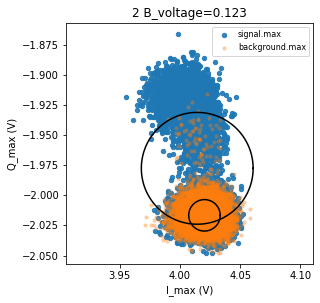

In [9]:
# plot of the maximums IQ plane for different traces during the time segment between
#signal_start-signal end (blue)- mixture of signal and background maximums,
#and bg_start-bg_end(orange)- mostly only the maximum of the background since the bleep should already have ocurred

%matplotlib inline


title="B_voltage=0.123"
signal_start=0  # in us
signal_end=400  # 

bg_start=1460
bg_end=1860

# IQ_plot: get the max of X and Y for signal and bg time window. The circles are centred at the mean and radius = std

X_signal, Y_signal, X_bg, Y_bg=IQ_plot(str(id_1),title, sweep_40,X_40,Y_40,signal_start,signal_end, bg_start,bg_end) # maximum of the signal

In [10]:
# finds the angle called theta between the X axis and the line between the center of the orange and blue circles.
#In our case is not between 90 and -90 so we have to add np.pi

angle=np.arctan((np.mean(Y_signal)-np.mean(Y_bg) )/(np.mean(X_signal)-np.mean(X_bg) ) )+np.pi

distance, rubbish=projection(integer,X_40, Y_40,  sweep_40, angle)

In [11]:
angle

1.7231561940480011

# distance integration time 1

In [12]:

distance, rubbish=projection(integer,X, Y,  sweep, angle)

In [13]:
#np.savez('./compressed-traces-JPA-off-2.npz', distance)

In [14]:

#distance=np.load('./JPA_off_traces_simulated-2.npz')['sim_distance']


In [15]:
#plt.plot(file['arr_0'][5])

##  calculate parameters

In [16]:
# parameters to be extracted
signal_parameters={
  "mean_bg": 0,
  "std_bg": 0,
  "mean_up": 0,
  "std_up": 0,
  "t_int": 0,
  "t_out": 0,
}

signal_parameters_fit={
  "mean_bg": 0,
  "std_bg": 0,
  "mean_up": 0,
  "std_up": 0,
  "t_int": 0,
  "t_out": 0,
}

###  on t_int and t_out

where t_out is the time that it takes for the electron to leave the dot (time before the bleep)

t_in time that the electron takes to come back to the dot (bleep duration)

In [17]:
## Increase integration time to better determine the angle in the IQ plane
# create new arrays
factor = 20 # factor*T_int_original=Tint
#sweep=np.linspace(0,2000,len(distance[0]))

distance_40=np.zeros((len(distance),len( moving_average(distance[0], factor))))


acquisition_time=2000 # time of the trace in us
number_points=len(sweep) # number of points in the trace
print(number_points)
T_int_original=acquisition_time/number_points # original integration time (1us)
T_int=factor*T_int_original # new integration time

# new I and Q with moving averaged
distance_40=np.zeros((len(distance),len(moving_average(distance[0], factor))))
sweep_40=np.zeros(len(moving_average(distance[0], factor)))


for a in range(len(distance)):
    distance_40[a]=moving_average(distance[a], factor)
sweep_40=moving_average(sweep, factor)


1952


####  histogram of the maximums

In [20]:
maximum=np.zeros(len(distance)) # trace maximum during first 400 us
max_background_distance=np.zeros(len(distance)) # trace maximum during last 400 us

for a in range(len(distance)):
    minim= np.where(sweep_40>= 0)[0][0]
    maxim= np.where(sweep_40>= sweep_40.max())[0][0]

    
    
    maximum[a]=distance_40[a][minim:maxim].max()
    
    minim= np.where(sweep_40>= 1460)[0][0]
    maxim= np.where(sweep_40>= 1860)[0][0]

    
    max_background_distance[a]=(distance_40[a][minim:maxim]).max()
    
# create histogram for the maximums  
hist_max, bin_edges_max = np.histogram(maximum, bins=60,range=(maximum.min(),maximum.max()))    
hist_max_bg, bin_edges_max_bg = np.histogram(max_background_distance, bins=60,range=(maximum.min(),maximum.max()))   


Text(0, 0.5, 'histogram')

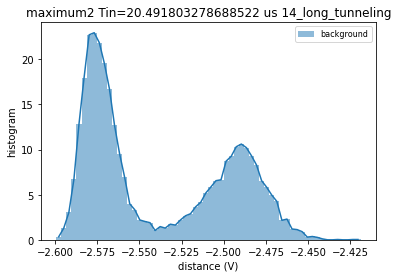

In [21]:
%matplotlib inline 


bin_axis=bin_edges_max[0:-1]+(bin_edges_max[1]-bin_edges_max[0])/2
normalisation=10000*(bin_edges_max[1]-bin_edges_max[0])
plt.bar(bin_axis, hist_max/normalisation, width=bin_edges_max[1]-bin_edges_max[0],label="background",alpha=0.5)
plt.plot(bin_axis, hist_max/normalisation)
#Tin=factor*2.5
Tin = T_int
plt.title("maximum"+str(id_1)+" Tin="+str(Tin)+" us" +" 14_long_tunneling")
plt.legend()

plt.xlabel("distance (V)")
plt.ylabel("histogram")

### JPA  plot traces 10us Tint

C:\Users\virgi\AppData\Local\Temp/ipykernel_15324/3104885129.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("JPA_OFF_TRACES.pdf",dpi=600, bbox_inches = "tight", rasterized='True')


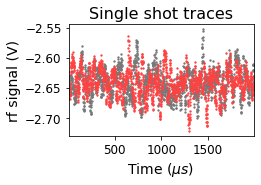

In [65]:
# plots 2 traces to compare spin up and down already projected
fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27				# Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0		 # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt	# width in inches
fig_height = fig_width*golden_mean		# height in inches
fig_size =	[fig_width,fig_height]
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.figsize'] = fig_size
plt.xlim((sweep_40.min(), sweep_40.max()))

#plt.ylim((y.min(), y.max())) 
plt.xlabel("Time ($\mu s$) ", {'color': 'k', 'fontsize': 14})
plt.ylabel("rf signal (V)", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)
#plt.ylim(0,30)


plt.title("Single shot traces",size=16)
#plt.plot(datax, out.best_fit, 'r-', label='best fit')
plt.scatter(sweep_40,distance_40[107],color=(120/255,120/255,120/255), marker='.',s=7, label=r'$ \uparrow$' )
plt.scatter(sweep_40,distance_40[300],color= (255/255,66/255,66/255),marker='.',s=7, label=r'$ \downarrow$' )
#plt.legend(loc=1, fontsize=10)




plt.savefig("JPA_OFF_TRACES.pdf",dpi=600, bbox_inches = "tight", rasterized='True')



In [66]:
## choose a threshold above which it's consider a bleep
t_thershold=-2.53

# select window for t_int
minim= np.where(sweep_40>= 40)[0][0]
maxim= np.where(sweep_40>= 300)[0][0]

t_in=np.zeros(len(distance)) # bleep duration
t_out=np.zeros(len(distance)) # times at which bleep starts

for a in range(len(distance)):
    
    if np.any(distance_40[a][minim:maxim]>= t_thershold):
        out = np.where(distance_40[a][minim:maxim]>= t_thershold)[0][0] # smallest time at which the signal is above the threshold
        t_out[a]=sweep_40[out+minim]
        inside = np.where(distance_40[a][minim:maxim]>=t_thershold)[0][-1] # last time at which signal is above the threshold
        t_in[a]=sweep_40[inside+minim]-t_out[a] # t_in= last point of the bllep- first point of the bleep
        
t_in = np.delete(t_in, np.where(t_in== 0)[0])
t_out = np.delete(t_out, np.where(t_out== 0)[0])
hist_in,bin_edges_in= np.histogram(t_in, bins=60,range=(t_in.min(),(t_in).max()))
hist_out,bin_edges_out= np.histogram(t_out, bins=60,range=(t_out.min(),(t_out).max()))

c:\users\virgi\anaconda3\envs\qcodes\lib\site-packages\lmfit\model.py:968: UserWarning: The keyword argument sigma does not match any arguments of the model function. It will be ignored.
  warnings.warn("The keyword argument %s does not " % name +


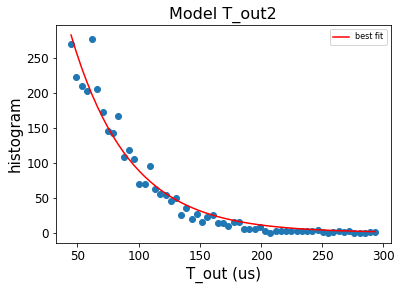

In [67]:
# Fit T_out to an exponential
def exponential(x, A,T_out):
    return A*np.exp(-x/T_out)
%matplotlib inline

time_out, time_out_error=model_fit1( bin_edges_out[1:-1], hist_out[1::],exponential, "T_out"+str(id_1),"T_out (us)","histogram",1, init={"A":200,'T_out':18})

signal_parameters["t_out"]=time_out["T_out"]

In [68]:
## choose a threshold above which it's consider a bleep


# select window for t_int
minim= np.where(sweep_40>= 20)[0][0]
maxim= np.where(sweep_40>= 1900)[0][0]

t_in=np.zeros(len(integer)) # bleep duration
t_out=np.zeros(len(integer)) # times at which bleep starts

for a in range(len(integer)):
    
    if np.any(distance_40[a][minim:maxim]>= t_thershold):
        out = np.where(distance_40[a][minim:maxim]>= t_thershold)[0][0] # smallest time at which the signal is above the threshold
        t_out[a]=sweep_40[out+minim]
        inside = np.where(distance_40[a][minim:maxim]>=t_thershold)[0][-1] # last time at which signal is above the threshold
        t_in[a]=sweep_40[inside+minim]-t_out[a] # t_in= last point of the bllep- first point of the bleep
        
t_in = np.delete(t_in, np.where(t_in== 0)[0])
t_out = np.delete(t_out, np.where(t_out== 0)[0])
hist_in,bin_edges_in= np.histogram(t_in, bins=100,range=(t_in.min(),(t_in).max()))
hist_out,bin_edges_out= np.histogram(t_out, bins=100,range=(t_out.min(),(t_out).max()))

c:\users\virgi\anaconda3\envs\qcodes\lib\site-packages\lmfit\model.py:968: UserWarning: The keyword argument sigma does not match any arguments of the model function. It will be ignored.
  warnings.warn("The keyword argument %s does not " % name +


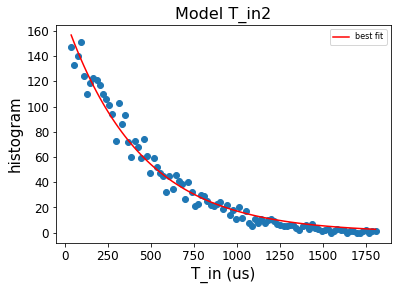

In [69]:
def exponential(x, A,T_in):
    return A*np.exp(-x/T_in)
%matplotlib inline

time_in, time_in_error=model_fit1( bin_edges_in[2:-2], hist_in[2:-1],exponential, "T_in"+str(id_1),"T_in (us)","histogram",1, init={"A":200,'T_in':40})
signal_parameters["t_in"]=time_in["T_in"]

In [70]:
signal_parameters

{'mean_bg': 0,
 'std_bg': 0,
 'mean_up': 0,
 'std_up': 0,
 't_int': 0,
 't_out': 47.833033656780664,
 't_in': 436.06703990665557}

### Getting noise


In [71]:
# GETTing std and mean from background for I and Q
minim= np.where(sweep>= 1600)[0][0]
maxim= np.where(sweep>= 2000)[0][0]

std_distance=np.std(np.transpose(distance)[minim:maxim]) # mean of the background I
signal_low_distance=np.mean(np.transpose(distance)[minim:maxim]) # std of the background I
signal_parameters["mean_bg"]=signal_low_distance
signal_parameters["std_bg"]=std_distance

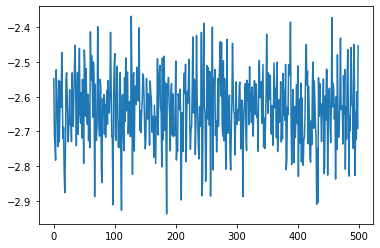

In [76]:
# vs power
# for 5    12
# for 4    1
# for 3    490
# for 2    300
# for 1    0

# vs voltage

# for 1   10
# for 2   12
# for 3   300
# for 4   10
# for 5   107

id_number=300
plt.plot(distance[id_number][0:500])
signal_parameters["mean_up"]=np.mean(distance[id_number][0:500])
signal_parameters["std_up"]=np.std(distance[id_number][100:300])

In [28]:
up_down=np.zeros(len(distance))
maximum=np.zeros(len(distance))
background_distance=np.zeros(len(distance))
max_background_distance=np.zeros(len(distance))

for a in range(len(distance)):
    minim= np.where(sweep_40>= 0)[0][0]
    maxim= np.where(sweep_40>= 399)[0][0]

    
    up_down[a]=np.mean(distance[a][minim:maxim])
    maximum[a]=distance[a][minim:maxim].max()
    
    minim= np.where(sweep_40>= 1460)[0][0]
    maxim= np.where(sweep_40>= 1860)[0][0]

    background_distance[a]=np.mean(distance[a][minim:maxim])
    max_background_distance[a]=(distance[a][minim:maxim]).max()
    
  
hist_max, bin_edges_max = np.histogram(maximum, bins=60,range=(maximum.min(),maximum.max()))    
hist_max_bg, bin_edges_max_bg = np.histogram(max_background_distance, bins=60,range=(maximum.min(),maximum.max()))   


Text(0, 0.5, 'histogram')

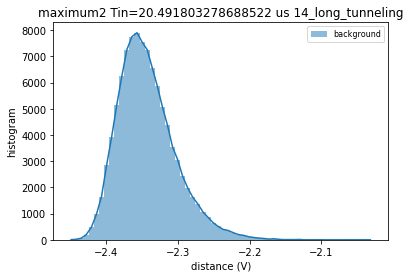

In [29]:
%matplotlib inline 
## 30 first us removed
bin_axis_bg=bin_edges_max_bg[0:-1]+(bin_edges_max_bg[1]-bin_edges_max_bg[0])/2

plt.bar(bin_axis_bg, hist_max_bg, width=bin_edges_max_bg[1]-bin_edges_max_bg[0],label="background",alpha=0.5)
plt.plot(bin_axis_bg, hist_max_bg)
#Tin=factor*2.5
Tin = T_int
plt.title("maximum"+str(id_1)+" Tin="+str(Tin)+" us" +" 14_long_tunneling")
plt.legend()

plt.xlabel("distance (V)")
plt.ylabel("histogram")

In [30]:
def fmax_down(x, n_points, std, signal_low):
    PDF_max=np.zeros(len(x))
    for a in range(len(x)):
        gaussian=1/std/np.sqrt(2*np.pi)*np.exp(-1/2*((x[a]-signal_low)/std)**2)
        F_function=1/2*(1+math.erf((x[a]-signal_low)/std/np.sqrt(2)))
        PDF_max[a]=n_points*F_function**(n_points-1)*gaussian
    return PDF_max

In [31]:
delta_t=(maxim-minim)
mean_bg=np.mean(background_distance)
std_bg=np.std(distance[a][minim:maxim])
normalisation=(bin_edges_max_bg[1]-bin_edges_max_bg[0])*10000

fit_results=fit(bin_edges_max_bg[0:-1], hist_max_bg/normalisation, fmax_down, init={"signal_low":mean_bg,"std":std_bg},fixed = {'n_points':delta_t})

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

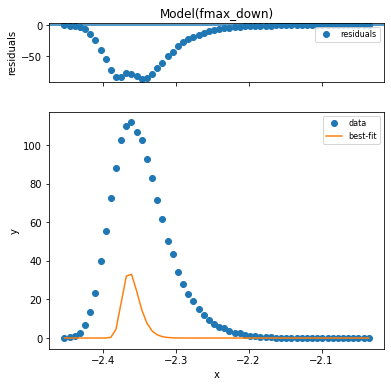

In [32]:
fit_results.plot()

In [33]:
fit_results

## JPA off Final parameters

In [34]:
signal_parameters

{'mean_bg': -2.6427917615361505,
 'std_bg': 0.10148564935088496,
 'mean_up': -2.646304100938416,
 'std_up': 0.09590352698577818,
 't_int': 0,
 't_out': 56.63873533617122,
 't_in': 453.85162520899223}

# Fit to experiements tint=0

In [38]:
signal_parameters
signal_parameters["std_up"]=signal_parameters["std_bg"]

In [39]:
# REAL DATA HISTOGRAM
maximum=np.zeros(len(distance))
max_background_distance=np.zeros(len(distance))

for a in range(len(distance)):
    minim= np.where(sweep>= 0)[0][0]
    maxim= np.where(sweep>= 2000)[0][0]

    
    maximum[a]=distance[a][minim:maxim].max()
    
    
  
hist_max, bin_edges_max = np.histogram(maximum, bins=60,range=(maximum.min(),maximum.max()))    


In [40]:
# SIMULATION- CREATE DATA

signal_low=signal_parameters["mean_bg"]
signal_high=signal_parameters["mean_up"]
std_bg=signal_parameters["std_bg"]
std_up=signal_parameters["std_up"]


t_in=signal_parameters["t_in"]
t_out=signal_parameters["t_out"]

A=0.5

n_traces=10000
n_points_time=1952

range_min=maximum.min()
range_max=maximum.max()

sim_distance, spin_sim= simulate_distance(A,std_bg,std_up ,signal_low,signal_high,t_out,t_in,n_points_time, n_traces,sweep)
   

# SIMULATION HISTOGRAM
maximum_sim=np.zeros(len(sim_distance))

for a in range(len(sim_distance)):
    minim= np.where(sweep>= 0)[0][0]
    maxim= np.where(sweep>= 2000)[0][0]

    
    maximum_sim[a]=sim_distance[a][minim:maxim].max()
    
    
  
hist_max_sim, bin_edges_max_sim = np.histogram(maximum_sim, bins=60,range=(maximum_sim.min(),maximum_sim.max()))    


No handles with labels found to put in legend.


Text(0, 0.5, 'histogram')

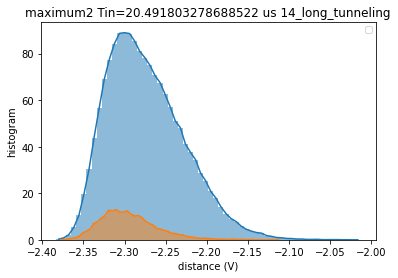

In [41]:
%matplotlib inline 
## 30 first us removed
bin_axis=bin_edges_max[0:-1]+(bin_edges_max[1]-bin_edges_max[0])/2
normalisation=10000*(bin_edges_max[1]-bin_edges_max[0])
plt.bar(bin_axis, hist_max/normalisation, width=bin_edges_max[1]-bin_edges_max[0],alpha=0.5)
plt.plot(bin_axis, hist_max/normalisation)


bin_axis=bin_edges_max_sim[0:-1]+(bin_edges_max_sim[1]-bin_edges_max_sim[0])/2
normalisation=10000*(bin_edges_max_sim[1]-bin_edges_max_sim[0])
plt.bar(bin_axis, hist_max_sim/normalisation, width=bin_edges_max_sim[1]-bin_edges_max_sim[0],alpha=0.5)
plt.plot(bin_axis, hist_max_sim/normalisation)

#Tin=factor*2.5
Tin = T_int
plt.title("maximum"+str(id_1)+" Tin="+str(Tin)+" us" +" 14_long_tunneling")
plt.legend()

plt.xlabel("distance (V)")
plt.ylabel("histogram")

## Tint=20

In [26]:
## REAL DATA MOVING AVERAGE
factor = 20 # factor*T_int_original=Tint
num_bins=100
distance_40=np.zeros((len(distance),len( moving_average(distance[0], factor))))


acquisition_time=2000 # time of the trace in us
number_points=len(sweep) # number of points in the trace
print(number_points)
T_int_original=acquisition_time/number_points # original integration time (1us)
T_int=factor*T_int_original # new integration time


# new I and Q with moving averaged
distance_40=np.zeros((len(distance),len(moving_average(distance[0], factor))))
sweep_40=np.zeros(len(moving_average(distance[0], factor)))


for a in range(len(X)):
    distance_40[a]=moving_average(distance[a], factor)
sweep_40=moving_average(sweep, factor)

# HISTOGRAM WITH REAL DATA
maximum=np.zeros(len(distance_40))
max_background_distance=np.zeros(len(distance_40))

for a in range(len(distance)):
    minim= np.where(sweep_40>= 0)[0][0]
    maxim= np.where(sweep_40>= sweep_40.max())[0][0]

    
    maximum[a]=distance_40[a][minim:maxim].max()
    
range_min=maximum.min()
range_max=maximum.max()
  
hist_max, bin_edges_max = np.histogram(maximum, bins=num_bins,range=(maximum.min(),maximum.max()))    


1952


In [1038]:
## SIMULATION MOVING AVERAGE

sim_distance_40=np.zeros((len(sim_distance),len( moving_average(sim_distance[0], factor))))


# new I and Q with moving averaged
sim_distance_40=np.zeros((len(sim_distance),len(moving_average(sim_distance[0], factor))))


for a in range(len(sim_distance)):
    sim_distance_40[a]=moving_average(sim_distance[a], factor)

# HISTOGRAM WITH SIMULATION
maximum_sim=np.zeros(len(sim_distance_40))

for a in range(len(sim_distance)):
    minim= np.where(sweep>= 0)[0][0]
    maxim= np.where(sweep>= sweep_40.max())[0][0]

    
    maximum_sim[a]=sim_distance_40[a][minim:maxim].max()
    
    
  
hist_max_sim, bin_edges_max_sim = np.histogram(maximum_sim, bins=num_bins,range=(maximum_sim.min(),maximum_sim.max()))    

NameError: name 'bin_edges_max_sim' is not defined

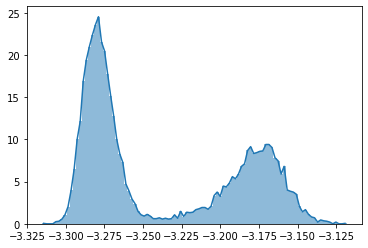

In [27]:
%matplotlib inline 
## PLOT
bin_axis=bin_edges_max[0:-1]+(bin_edges_max[1]-bin_edges_max[0])/2
normalisation=10000*(bin_edges_max[1]-bin_edges_max[0])
plt.bar(bin_axis, hist_max/normalisation, width=bin_edges_max[1]-bin_edges_max[0],alpha=0.5)
plt.plot(bin_axis, hist_max/normalisation)


bin_axis_sim=bin_edges_max_sim[0:-1]+(bin_edges_max_sim[1]-bin_edges_max_sim[0])/2
normalisation_sim=10000*(bin_edges_max_sim[1]-bin_edges_max_sim[0])
plt.bar(bin_axis_sim, hist_max_sim/normalisation_sim, width=bin_edges_max_sim[1]-bin_edges_max_sim[0],alpha=0.5)
plt.plot(bin_axis_sim, hist_max_sim/normalisation_sim)


Tin = T_int
plt.title("maximum"+str(id_1)+" Tin="+str(Tin)+" us" +" 14_long_tunneling")
plt.legend()

plt.xlabel("distance (V)")
plt.ylabel("histogram")

In [1040]:
maximum.min()

-3.3152444813454167

## fit parameters

In [1045]:
signal_low=signal_parameters["mean_bg"]
signal_high=signal_parameters["mean_up"]
std_bg=signal_parameters["std_bg"]
std_up=signal_parameters["std_up"]


t_in=signal_parameters["t_in"]
t_out=signal_parameters["t_out"]

A=0.5
t_int=factor
num_bins = num_bins
n_traces=10000
t_max = 2000
n_points_time=1952

range_min=maximum.min()
range_max=maximum.max()



fitresult= fit(bin_axis, hist_max/normalisation,fit_histogram_v2, fixed = {'range_min':range_min,'range_max':range_max,'t_int':t_int,'t_out':t_out, 't_in':t_in, 't_max':t_max, 'n_points_time': n_points_time, 'n_traces':n_traces, 'num_bins':num_bins, 'plot_histo':0, 'signal_low': signal_low , 'std_low': std_bg}, init = {'std_up':std_up, "A":A,"signal_high":signal_high,},bounds={'std_up':[0.09,0.12], "A":[0.45,0.55]}, step_size = 2e-2 )


(<Figure size 239.103x239.103 with 2 Axes>,
 GridSpec(2, 1, height_ratios=[1, 4]))

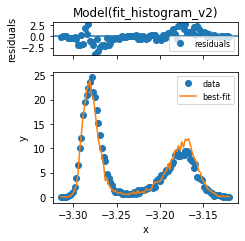

In [1046]:
fitresult.plot()

In [1047]:
factor_ntraces = 10

A = fitresult.params['A'].value
range_min = fitresult.params['range_min'].value
range_max = fitresult.params['range_max'].value
std_low = fitresult.params['std_low'].value 
std_up = fitresult.params['std_up'].value
signal_low = fitresult.params['signal_low'].value 
signal_high = fitresult.params['signal_high'].value
t_int = fitresult.params['t_int'].value
t_out = fitresult.params['t_out'].value
t_in = fitresult.params['t_in'].value
t_max = fitresult.params['t_max'].value
n_points_time = fitresult.params['n_points_time'].value 
n_traces = fitresult.params['n_traces'].value * factor_ntraces 
num_bins = fitresult.params['num_bins'].value
num_bins = 100

####  definitive parameters fit

In [1048]:
signal_parameters_fit={
  "mean_bg": 0,
  "std_bg": 0,
  "mean_up": 0,
  "std_up": 0,
  "t_int": 0,
  "t_out": 0,
    "A":0,
}

signal_parameters_fit["A"]=A
signal_parameters_fit["std_bg"]=std_low
signal_parameters_fit["std_up"]=std_up
signal_parameters_fit["mean_bg"]=signal_low
signal_parameters_fit["mean_up"]=signal_high
signal_parameters_fit["t_int"]=t_int
signal_parameters_fit["t_in"]=t_in
signal_parameters_fit["t_out"]=t_out

In [1049]:
signal_parameters_fit

{'mean_bg': -3.3493535124031806,
 'std_bg': 0.10143317709914586,
 'mean_up': -3.224155519095218,
 'std_up': 0.10172068194686833,
 't_int': 20,
 't_out': 22.419067336281234,
 'A': 0.500042687664294,
 't_in': 313.81919653814515}

In [1050]:
import json
with open('JPA_off_vs_power_'+str(id_1)+'.json', 'w') as fp:
    json.dump(signal_parameters_fit, fp)


C:\Users\virgi\AppData\Local\Temp/ipykernel_3128/3013448970.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("histogram.png",dpi=600, bbox_inches = "tight", rasterized='True')


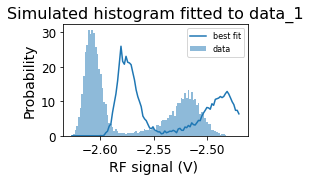

In [28]:
## Comparing data and simulation


fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27				# Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0		 # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt	# width in inches
fig_height = fig_width*golden_mean		# height in inches
fig_size =	[fig_width,fig_height]
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.figsize'] = fig_size
t_max=2000
n_points_time=1952
n_traces=10000
# Plot data as histogram
# -----------------------
bin_axis=bin_edges_max[0:-1]+(bin_edges_max[1]-bin_edges_max[0])/2
normalisation=10000*(bin_edges_max[1]-bin_edges_max[0])
plt.bar(bin_axis, hist_max/normalisation, width=bin_edges_max[1]-bin_edges_max[0],label="data",alpha=0.5)

# Plot simulation as curve
# -----------------------
bins, histo=simulate_histogram_out(A,range_min,range_max,std_low,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins , 0)
#f_hist_inter = interp1d(bins,histo, kind='cubic')
x=np.linspace(-3,0,1000)
#plt.plot(x,f_hist_inter(x), label='best fit')
plt.plot(bins, histo, label='best fit')

# Caption
#------------------------
plt.legend()
plt.xlabel("Signal")
plt.ylabel("Probability")
plt.title('Simulated histogram vs data_ Tint=%f'%t_int)

plt.xlabel("RF signal (V) ", {'color': 'k', 'fontsize': 14})
plt.ylabel("Probability", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)
#plt.ylim(0,30)
plt.title("Simulated histogram fitted to data_1",size=16)
plt.savefig("histogram.png",dpi=600, bbox_inches = "tight", rasterized='True')



In [26]:
import json
with open('JPA_off_vs_power_2.json', 'r') as file:
    signal_parameters_fit_read=json.load(file)

In [27]:
A=signal_parameters_fit_read["A"]
std_low=signal_parameters_fit_read["std_bg"]
std_up=signal_parameters_fit_read["std_up"]
signal_low=signal_parameters_fit_read["mean_bg"]
signal_high=signal_parameters_fit_read["mean_up"]
t_int=20
t_in=signal_parameters_fit_read["t_in"]
t_out=signal_parameters_fit_read["t_out"]

In [19]:
signal_parameters_fit_read

{'mean_bg': -3.3493535124031806,
 'std_bg': 0.10143317709914586,
 'mean_up': -3.224155519095218,
 'std_up': 0.10172068194686833,
 't_int': 20,
 't_out': 22.419067336281234,
 'A': 0.500042687664294,
 't_in': 313.81919653814515}

In [1136]:
# Calculate fidelity as David

# SIMULATION- CREATE DATA

signal_low=signal_parameters_fit_read["mean_bg"]
signal_high=signal_parameters_fit_read["mean_up"]
std_bg=signal_parameters_fit_read["std_bg"]
std_up=signal_parameters_fit_read["std_up"]


t_in=signal_parameters_fit_read["t_in"]
t_out=signal_parameters_fit_read["t_out"]

A=signal_parameters_fit_read["A"]

n_traces=100000
n_points_time=1952



sim_distance, spin_sim= simulate_distance(A,std_bg,std_up ,signal_low,signal_high,t_out,t_in,n_points_time, n_traces,sweep)

## SIMULATION MOVING AVERAGE

sim_distance_40=np.zeros((len(sim_distance),len( moving_average(sim_distance[0], factor))))


# new I and Q with moving averaged
sim_distance_40=np.zeros((len(sim_distance),len(moving_average(sim_distance[0], factor))))


for a in range(len(sim_distance)):
    sim_distance_40[a]=moving_average(sim_distance[a], factor)

# HISTOGRAM WITH SIMULATION
maximum_sim=np.zeros(len(sim_distance_40))

for a in range(len(sim_distance)):
    minim= np.where(sweep>= 0)[0][0]
    maxim= np.where(sweep>= sweep_40.max())[0][0]

    
    maximum_sim[a]=sim_distance_40[a][minim:maxim].max()
range_min=maximum_sim.min()
range_max=maximum_sim.max()

In [1137]:
"""np.savez('./JPA_off_traces_simulated-2.npz', sim_distance=sim_distance, spin_sim=spin_sim)
np.load('./JPA_off_traces.npz').files"""

"np.savez('./JPA_off_traces_simulated-2.npz', sim_distance=sim_distance, spin_sim=spin_sim)\nnp.load('./JPA_off_traces.npz').files"

In [1138]:
epsilon=0.005
signal_threshold = np.linspace(range_min + epsilon, range_max - epsilon,50)

fidelity_up = []
fidelity_down = []

spin_up_maximums=maximum_sim[np.where(spin_sim==0)[0]]
spin_down_maximums=maximum_sim[np.where(spin_sim==1)[0]]
for signal in signal_threshold:
            
            integ_up=len(np.where(spin_up_maximums<=signal)[0])
            integ_down=len(np.where(spin_down_maximums>=signal)[0])
            
            fidelity_up.append(1-integ_up/n_traces)
            fidelity_down.append(1-integ_down/n_traces)
           

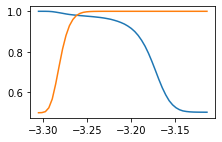

In [1139]:
plt.plot(signal_threshold,fidelity_up)
plt.plot(signal_threshold,fidelity_down)

In [1140]:
visibility=np.array(fidelity_up)+np.array(fidelity_down)-1
visibility.max()

0.9734500000000001

In [1130]:
# CALCULATE FIDELITY AS CONSTANCE

epsilon = 0.005 
#epsilon is so that we make sure we don't integrate out of the boundaries of the interpolated function
#n_traces = int(n_traces/factor_ntraces)

signal_threshold = np.linspace(range_min + epsilon, range_max - epsilon,50)
t_max=2000

fidelity_down, fidelity_up, error = fidelity_Virginia(signal_threshold,A,range_min,range_max,std_low,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins , 0)


20
number of traces for bg = 100000 number of up traces = 50103


C:\Users\virgi\AppData\Local\Temp/ipykernel_19416/4279502438.py:457: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integ_down = integrate.quad(f_hist_down, signal, np.max(histo_down[0]))
C:\Users\virgi\AppData\Local\Temp/ipykernel_19416/4279502438.py:460: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from sp

max visibility = 0.9733414945702967 at -2.546989572545515


C:\Users\virgi\AppData\Local\Temp/ipykernel_19416/3730769154.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fidelity.png",dpi=600, bbox_inches = "tight", rasterized='True')


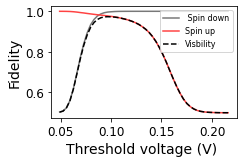

In [1131]:
plt.figure()
fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27				# Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0		 # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt	# width in inches
fig_height = fig_width*golden_mean		# height in inches
fig_size =	[fig_width,fig_height]
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.figsize'] = fig_size

plt.plot(signal_threshold-signal_low,fidelity_down, color=(120/255,120/255,120/255), label=r' Spin down')#Fidelity$_{\downarrow}$')


plt.plot(signal_threshold-signal_low,fidelity_up, color= (255/255,66/255,66/255), label=r'Spin up')#Fidelity$_{\uparrow}$' )
plt.plot(signal_threshold-signal_low,np.array(fidelity_up)+np.array(fidelity_down)-1,'--',label='Visbility',c='k')

plt.legend(loc=1, fontsize=8)
plt.xlabel("Threshold voltage (V) ", {'color': 'k', 'fontsize': 14})
plt.ylabel("Fidelity", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)

plt.savefig("fidelity.png",dpi=600, bbox_inches = "tight", rasterized='True')
print("max visibility =", np.max(np.array(fidelity_up)+np.array(fidelity_down)-1),'at', signal_threshold[np.argmax(np.array(fidelity_up)+np.array(fidelity_down)-1)])

In [1132]:
visibility=np.array(fidelity_up)+np.array(fidelity_down)-1
visibility.max()

0.9733414945702967